In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from DSH import MIfile as MI
from DSH import CorrMaps as CM
from DSH import VelMaps as VM

# Introduction

The working principle of DSH is to infer displacements based on correlation data. 
To do that, we first need to know the velocity profile along the optical axis and to model the correlation function for such a profile. DSH has two choices of profile: affine and parabolic profiles. 
Both model functions can be sampled using: 

```python
VM.g2m1_sample(zProfile='Parabolic', q=1.0, d0=1.0, baseline=0.0, sample_dr=None, max_dr=None, step_dr=0.001)
```

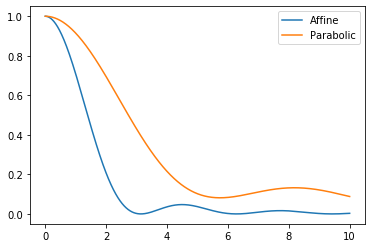

In [2]:
for cur_profile in ['Affine', 'Parabolic']:
    cur_model = VM.g2m1_sample(cur_profile, max_dr=10)
    plt.plot(cur_model[0], cur_model[1], label=cur_profile)
plt.legend()

Displacements can then be computed by inverting the correlation data, which can be done using ```VM.invert_monotonic(data, _lut, overflow_to_nan=False)``` for displacements small enough, where the correlation functions are monotonically decreasing:

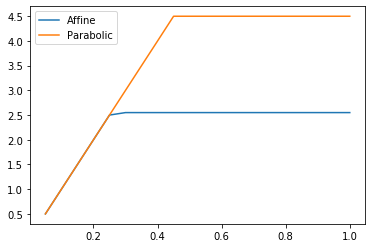

In [3]:
sample_t = np.linspace(0.05, 1, 20)
v = 10
for cur_profile in ['Affine', 'Parabolic']:
    sample_corr = VM.g2m1_sample(cur_profile, sample_dr=v*sample_t)
    cur_model = VM.g2m1_sample(cur_profile, sample_dr=None)
    sample_dr = VM.invert_monotonic(sample_corr, cur_model)
    plt.plot(sample_t, sample_dr, label=cur_profile)
plt.legend()

The displacements can then be used to derive a velocity map. In practice, this is done in two steps: 

    1. with a linear fit of the smallest displacements one can obtain a rough estimation of the instantaneous velocity 
    2. this can be used as initial guess for a Monte Carlo fitting procedure that aims at reproducing as closely as possible the measured correlations

# Load correlation data

To start with, we need to load the correlation data. We can do so from the root folder and the analysis configuration file:

```python
CM.LoadFromConfig(ConfigFile, outFolder=None)
```

In [4]:
froot = 'D:\\steaime\\Data\\Cracks\\S54\\1-0'
froot = 'C:\\Users\\steaime\\Documents\\Codes\\DSH\\DSHpy\\DSH\\test'
corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)
print(corr_maps)


|-----------------|
| CorrMaps class: |
|-----------------+---------------
| MI Filename     : None
| output folder   : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test
| lag times (01)  : [1]
| image range     : [0, 2, 1]
| crop ROI        : [200, 100, 100, 50]
| Kernel          : <Kernel [2D Gauss], 11x11, s=(2.5;1.5)>
|-----------------+---------------


For every pixel of these correlation maps, we can extract the correlation timetrace and combine all lagtimes in rows of a 2D map using

```python
corr_maps.GetCorrTimetrace(pxLocs, zRange=None, lagList=None, excludeLags=[])
```

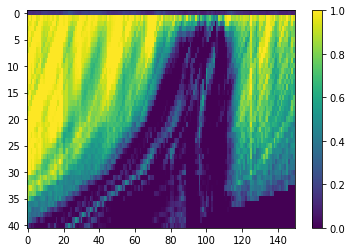

In [6]:
pxLoc = [500, 600]
load_tRange = [200, 350, 1]
cmap = corr_maps.GetCorrTimetrace(pxLoc, zRange=load_tRange)
plt.imshow(cmap, aspect='auto', vmin=0, vmax=1)
plt.colorbar()

A few values here are useless: the zero time delay and the zeroes in the bottom right corner (where the lagtime was long enough that t2=t1+tau exceeded the number of images).
We can get rid of d0 by specifying the lag list, and we can get rid of zeroes by setting it to NaN.

In addition, the analysis is done by considering both positive time delays and their negative symmetric, if available: this way the timepoints used to compute $v(t^*)$ will be cenetered on the correct time $t^*$.
The complete set of correlations available to be fitted would look like this:

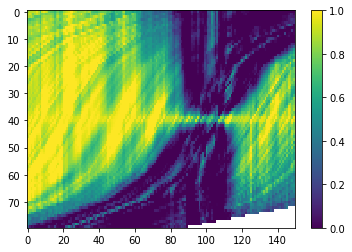

In [6]:
cmap_sym = corr_maps.GetCorrTimetrace(pxLoc, zRange=load_tRange, excludeLags=[0], lagFlip='BOTH')
cmap_sym[np.where(cmap_sym==0)]=np.nan
plt.imshow(cmap_sym, aspect='auto', vmin=0, vmax=1)
plt.colorbar()

Analysis is performed within the ```VelMaps``` class, that contains reference to the correlation maps and to experimental parameters such as velocity profile and scattering vector:

```python
vel_maps = VM.VelMaps(corr_maps, z_profile='Parabolic', q_value=1.0, t_range=None)
```

In [7]:
vel_maps = VM.VelMaps(corr_maps, z_profile='Parabolic', q_value=4.25, t_range=load_tRange)

# Step 1: linear fit

A first estimate for the velocity map can be obtained by converting the correlation data into displacements and linearly fitting dr(tau)

In [8]:
model = VM.g2m1_sample('Parabolic', q=4.25)
dr_timetrace = np.empty_like(cmap_sym)
for lidx in range(cmap_sym.shape[0]):
    dr_timetrace[lidx] = VM.invert_monotonic(cmap_sym[lidx], model)

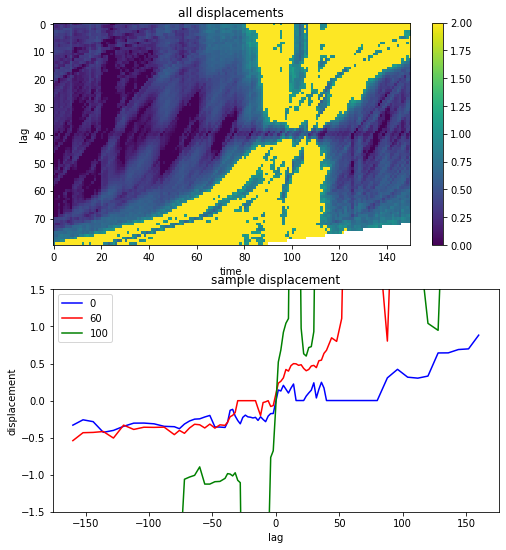

In [9]:
plot_times = [0, 60, 100]
plot_colors = ['b', 'r', 'g']
fig, ax = plt.subplots(2, figsize=(8, 9))
cb = ax[0].imshow(dr_timetrace, aspect='auto', vmin=0, vmax=2)
ax[0].set_xlabel('time')
ax[0].set_ylabel('lag')
ax[0].set_title('all displacements')
fig.colorbar(cb, ax=ax[0])
lag_pos = corr_maps.lagList.copy()
lag_pos.sort()
lag_neg = corr_maps.lagList.copy()
lag_neg.sort(reverse=True)
sign_list = list(np.ones_like(lag_pos)*-1) + list(np.ones_like(lag_pos))
signed_lags = np.multiply(lag_neg + lag_pos, sign_list)
for tidx in range(len(plot_times)):
    ax[1].plot(signed_lags, np.multiply(dr_timetrace[:,plot_times[tidx]], sign_list),\
               plot_colors[tidx]+'-', label=str(plot_times[tidx]))
ax[1].set_xlabel('lag')
ax[1].set_ylabel('displacement')
ax[1].set_ylim([-1.5, 1.5])
ax[1].set_title('sample displacement')
ax[1].legend()

Data is noisy, eventually overflowing the invertible range, and eventually velocity may evolve significantly between the two times that are correlated ($t_1$ and $t_2=t_1+\tau$), so that the relationship can *a priori* be nonlinear.

Thus, we first need to find a convenient subset of lagtimes to be used to evaluate $v(t)$. This is based on a number of parameters that need to be arbitrarily tuned until the analysis yields acceptable results. This is not a huge problem in itself since this is only the first step: a precise value for $v(t)$ helps the Monte Carlo algorithm afterwards but it is not strictly necessary. These parameters are:

    - consec_only         : boolean. 
                            if True, only select sorrelation chunk with consecutive True value of the mask around tau=0
    - max_holes           : integer, only used if consecutive_only==True.
                            Largest hole to be ignored before chunk is considered as discontinued
    - mask_opening        : None or integer > 1.
                            if not None, apply binary_opening to the mask for a given pixel as a function of lagtime
                            This removes thresholding noise by removing 
                            N-lag-wide unmasked domains where N=mask_opening_range
    - symm_only           : only considers time delays for which both positive and negative data are available.
                            If symm_only==True, v(t) is evaluated using data actually centered on t
    - conservative_cutoff : only consider correlation data above this threshold value
    - generous_cutoff     : when correlations above conservative_cutoff are not enough for linear fitting,
                            include first lagtimes provided correlation data is above this more generous threshold

Let's see what is the result varying those parameters:

C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\VelMaps.py:606: RuntimeWarning: divide by zero encountered in true_divide
  cur_slopes = np.true_divide(cur_dr, cur_dt)
C:\Users\steaime\.conda\envs\DSH\lib\site-packages\numpy\lib\nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


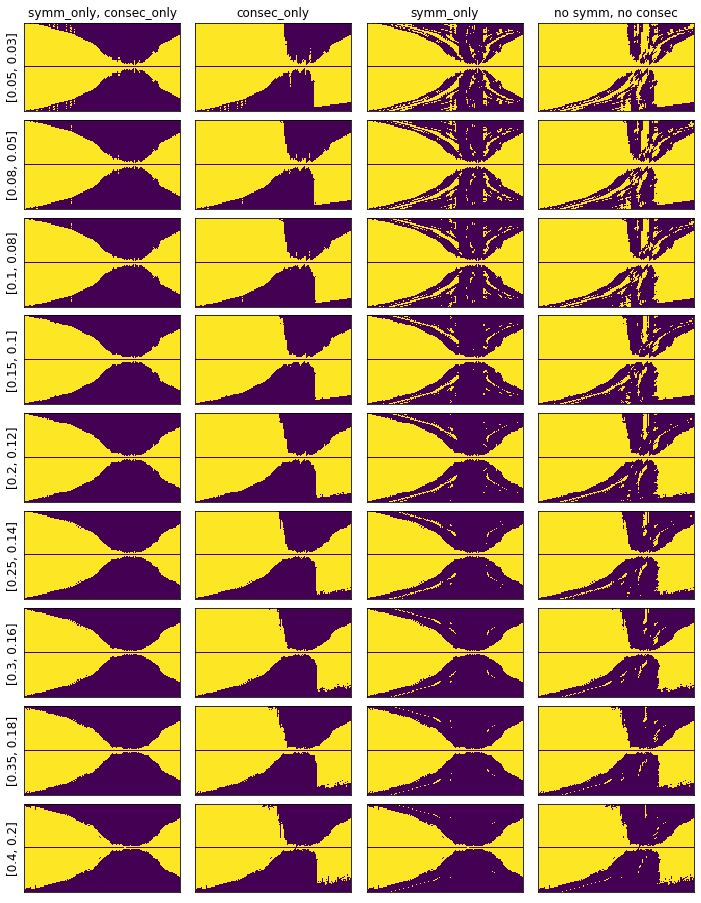

In [11]:
cons_cut_list = [0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
gen_cut_list = [0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
fig, ax = plt.subplots(nrows=len(cons_cut_list), ncols=4, figsize=(12, 16),\
                       gridspec_kw={'wspace':0.1, 'hspace':0.1})
param_labels = ['symm_only, consec_only', 'consec_only', 'symm_only', 'no symm, no consec']
for i in range(4):
    ax[0,i].set_title(param_labels[i])
for i in range(len(cons_cut_list)):
    _, _, _, mask = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method='mean', simpleOut=False)
    ax[i,0].imshow(mask, aspect='auto')
    _, _, _, mask = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=False, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method='mean', simpleOut=False)
    ax[i,1].imshow(mask, aspect='auto')
    _, _, _, mask = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=False,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method='mean', simpleOut=False)
    ax[i,2].imshow(mask, aspect='auto')
    _, _, _, mask = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=False, consec_only=False,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method='mean', simpleOut=False)
    ax[i,3].imshow(mask, aspect='auto')
    for j in range(4):
        ax[i,j].xaxis.set_ticks([])
        ax[i,j].yaxis.set_ticks([])
    ax[i,0].set_ylabel(str([cons_cut_list[i], gen_cut_list[i]]), size='large')


The analysis has one additional parameter ```signed_lags``` leaving the choice of keeping track of the sign of the time delay or working with absolute values only.
Note that working with absolute values will "flatten" the linear fits, reducing slopes and increasing intercepts
It does a much better job accounting for noise contributions to correlations close to 1.
if ```signed_lags==False```, the artificial correlation value at ```lag==0``` will not be processed
(it is highly recommended to set ```signed_lags``` to ```False```).

Slopes can be obtained with different methods:

    - linfit : use scipy.stats.linregress to perform a linear fit (with slope and intercept)
    - lstsq : use numpy.linalg.lstsq to perform a linear regression setting the intercept to zero
    - lstsq_wint : use numpy.linalg.lstsq to perform a linear regression without setting the intercept to zero
                   (should be the same as linfit)
    - mean : simply average on point-wise slopes, defined as dt[i]/tau[i]

Let's compare how all these perform for one choice of cutoff values:

In [12]:
%%time
res_list = []
method_list = ['linfit', 'lstsq_wint', 'lstsq', 'mean']
for method in method_list:
    res_list.append(vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=0.1,\
                                              generous_cutoff=0.08, method=method, simpleOut=False))

Wall time: 1.18 s


Text(0.5, 0, 'time [image units]')

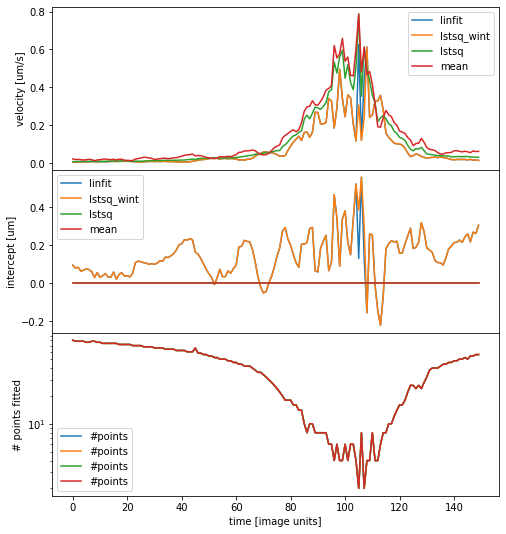

In [13]:
fig, ax = plt.subplots(3, sharex='all', figsize=(8, 9))
plt.subplots_adjust(hspace = .001)
ax[0].set_ylabel('velocity [um/s]')
ax[1].set_ylabel('intercept [um]')
ax[2].set_ylabel('# points fitted')
for i in range(len(res_list)):
    ax[0].plot(res_list[i][0], label=method_list[i])
    ax[1].plot(res_list[i][1], label=method_list[i])
    ax[2].plot(np.count_nonzero(res_list[i][3], axis=0), label='#points')
for cur_ax in ax:
    cur_ax.legend()
ax[2].set_yscale('log')
ax[2].set_xlabel('time [image units]')

One way to see how well this captures the actual correlation data is to use this $v(t)$ profile to compute the expected correlation maps: this can be done using 

```python
VM.compute_displ_multilag(v, lagtimes, dt=1.0)
```

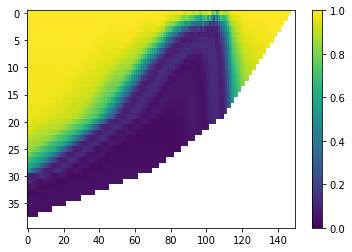

In [15]:
exp_displ = VM.compute_displ_multilag(res_list[0][0], np.asarray(corr_maps.lagList),\
                                      dt=corr_maps.imgRange[2]/vel_maps.GetFPS())
exp_cmap = VM.g2m1_parab(exp_displ, vel_maps.qValue)
plt.imshow(exp_cmap, aspect='auto', vmin=0, vmax=1)
plt.colorbar()

We can then compute a mean square error (MSE):

Mean square error: 0.06944530040704562


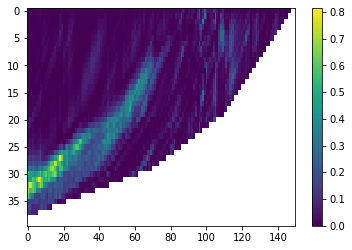

In [16]:
cmap_nozero = corr_maps.GetCorrTimetrace(pxLoc, zRange=load_tRange, excludeLags=[0], lagFlip=False)
cmap_err = np.square(np.subtract(exp_cmap, cmap_nozero))
print('Mean square error: ' + str(np.nanmean(cmap_err)))
plt.imshow(cmap_err, aspect='auto')
plt.colorbar()

We can now use this MSE to find the best choice of parameters:

In [17]:
def compute_MSE(vel):
    exp_displ = VM.compute_displ_multilag(vel, np.asarray(corr_maps.lagList), dt=corr_maps.imgRange[2]/vel_maps.GetFPS())
    exp_cmap = VM.g2m1_parab(exp_displ, vel_maps.qValue)
    return np.square(np.subtract(exp_cmap, cmap_nozero))

In [18]:
%%time
resMSE = np.empty((len(cons_cut_list), 4, len(method_list)))
for i in range(len(cons_cut_list)):
    for j in range(len(method_list)):
        cur_vel, _ = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method=method_list[j], simpleOut=True)
        resMSE[i,0,j] = np.nanmean(compute_MSE(cur_vel))
        cur_vel, _ = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=False, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method=method_list[j], simpleOut=True)
        resMSE[i,1,j] = np.nanmean(compute_MSE(cur_vel))
        cur_vel, _ = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=False,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method=method_list[j], simpleOut=True)
        resMSE[i,2,j] = np.nanmean(compute_MSE(cur_vel))
        cur_vel, _ = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=False, consec_only=False,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=cons_cut_list[i],\
                                              generous_cutoff=gen_cut_list[i], method=method_list[j], simpleOut=True)
        resMSE[i,3,j] = np.nanmean(compute_MSE(cur_vel))

C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\VelMaps.py:661: RuntimeWarning: invalid value encountered in greater
  try_mask = corr_data > conservative_cutoff
C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\VelMaps.py:713: RuntimeWarning: divide by zero encountered in true_divide
  cur_slopes = np.true_divide(cur_dr, cur_dt)
C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\VelMaps.py:106: RuntimeWarning: invalid value encountered in subtract
  res[i,:-lagtimes[i]] = dt*np.subtract(csums[lagtimes[i]:], csums[:-lagtimes[i]])
C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\VelMaps.py:123: RuntimeWarning: invalid value encountered in multiply
  return (np.pi/4)*np.true_divide(np.square(np.abs(ssp.erf(np.sqrt(-1j*dotpr)))),np.abs(dotpr))


Wall time: 48.8 s


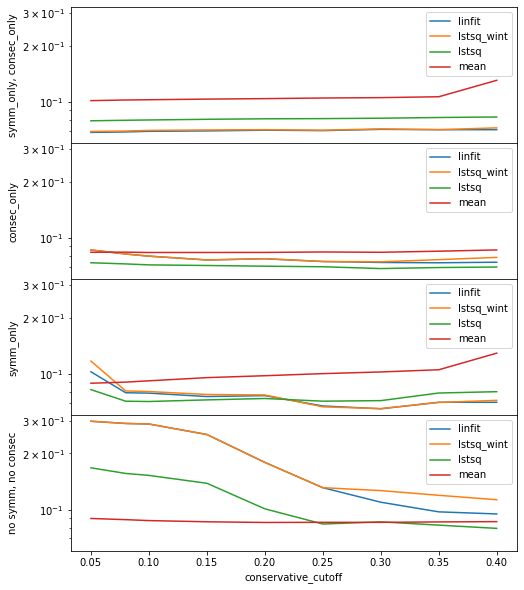

In [19]:
fig, ax = plt.subplots(4, figsize=(8, 10), sharey='all')
plt.subplots_adjust(hspace = .001)
for k in range(4):
    for j in range(len(method_list)):
        ax[k].plot(cons_cut_list, resMSE[:,k,j], label=method_list[j])
    ax[k].legend()
    ax[k].set_ylabel(param_labels[k])
ax[-1].set_xlabel('conservative_cutoff')
ax[0].set_yscale('log')

I have a prior preference for ```symm_only==True```, ```consc_only==True``` and ```method=='linfit'|'lstsq_wint'```. Let's have a closeup comparison

C:\Users\steaime\Documents\Research\Codes\DSH\DSHpy\DSH\VelMaps.py:661: RuntimeWarning: invalid value encountered in greater
  try_mask = corr_data > conservative_cutoff


Wall time: 355 ms
Wall time: 312 ms


Text(0.5, 1.0, 'lstsq_wint - MSE=0.07085521023933426')

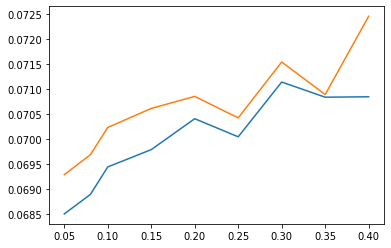

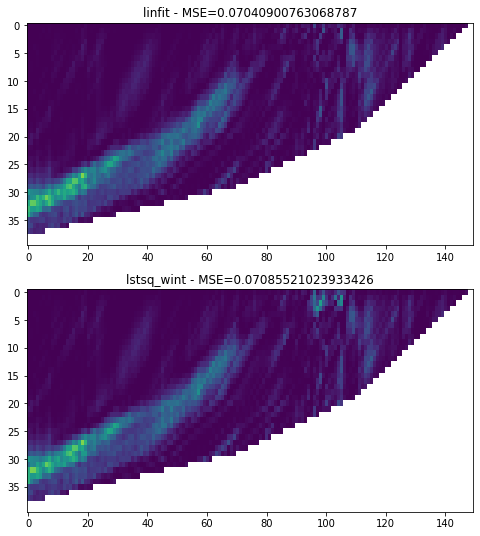

In [20]:
plt.plot(cons_cut_list, resMSE[:,0,0])
plt.plot(cons_cut_list, resMSE[:,0,1])
%time vel_linfit, _ = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=0.2,\
                                              generous_cutoff=0.1, method='linfit', simpleOut=True)
%time vel_lstsq, _ = vel_maps.ProcessSinglePixel(pxLoc, signed_lags=False, symm_only=True, consec_only=True,\
                                              max_holes=1, mask_opening=None, conservative_cutoff=0.2,\
                                              generous_cutoff=0.1, method='lstsq_wint', simpleOut=True)
fig, ax = plt.subplots(2, figsize=(8, 9))
ax[0].imshow(compute_MSE(vel_linfit), aspect='auto', vmin=0, vmax=1)
ax[0].set_title('linfit - MSE=' + str(np.nanmean(compute_MSE(vel_linfit))))
ax[1].imshow(compute_MSE(vel_lstsq), aspect='auto', vmin=0, vmax=1)
ax[1].set_title('lstsq_wint - MSE=' + str(np.nanmean(compute_MSE(vel_lstsq))))

Final choice. Let's add a running mean to start from a smoother initial condition

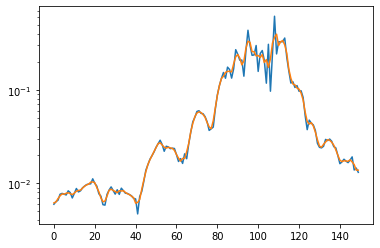

In [21]:
def running_mean(x, N):
    return np.true_divide(np.convolve(x, np.ones((N,))/N, mode='same'),\
                          np.convolve(np.ones_like(x), np.ones((N,))/N, mode='same'))
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)
vel_step1 = running_mean(vel_lstsq, 3)
fig, ax = plt.subplots()
ax.plot(vel_lstsq)
ax.plot(vel_step1)
ax.set_yscale('log')

# Step 2: Monte Carlo refinement

Overall the linear fit does a decent job. To refine this procedure and make it less sensitive to arbitrary parameters, we use this $v(t)$ as starting point for a Monte Carlo refinement that aims at reconstructing the MSE landscape and finding the MAP (maximum a posteriori). This can ve done using 

```python
vel_maps.MCsamplePixel(pxLoc, tRange, lagTimes, dt, velPrior, corrPrior, initGaussBall, nwalkers, nsteps=1000,\
                       corrStdfunc=corr_std_calc, corrStdfuncParams={}, regParam=0.0)
```

which has a few parameters that need to be tuned:

    velPrior : [prior_avg, prior_std]. prior_avg is the output of simple fitting procedure, whereas 
                                       prior_std needs to be assigned. Two possible choices are 
                                       a constant absolute uncertainty or a constant relative uncertainty
    corrPrior : [prior_avg, prior_std] Prior on correlation function parameters: [[d0_avg, base_avg], [d0_std, base_std]]
                                       if None, the default value [[1.0, 0.0], [0.01, 0.01]] will be used
    initGaussBall : start MC walkers from random positions centered on the unrefined velocities and with
                    a relative spread given by initGaussBall
    corrStdfunc :   function calculating uncertainties on correlation data taking as parameters
                    the correlation themselves plus eventual additional parameters.
                    Default is corr_std_calc, which assigns an exponential uncertainty

$$
\sigma(c_I)=\sigma_0 \exp\left(\frac{c_{ro}}{c_I}\right)^p
$$

                    parameters are:
                    - baseline (sigma_0). Default is 0.1
                    - rolloff (c_ro). Default is 0.15
                    - exponent (p). Default is 1
    regParam :      float>=0. Regularization parameter penalizing velocity fluctuations.
                    Default is regParam=0.0, which means no regularization

A priori the prior and the initial conditions only determine the burnin. In practice, they do make a difference because the sampling doesn't last forever.

Let's first see one example of how the refinement performs with one choice of parameters:

In [43]:
corr_prior = [[0.99, 0.03], [0.01, 0.01]]
rel_prior_std = 1.0
%time sample_mcmc = vel_maps.MCsamplePixel(pxLoc, load_tRange, np.asarray(corr_maps.lagList, dtype=int),\
                                    corr_maps.imgRange[2]*1.0/vel_maps.GetFPS(),\
                                    [vel_step1, rel_prior_std*np.abs(vel_step1)], corr_prior, 0.2, 400, 10000,\
                                   VM.corr_std_calc, {'baseline':0.3, 'rolloff':0.2}, 0.0)

Wall time: 1h 6min 43s


Text(0.5, 0, 'MC steps')

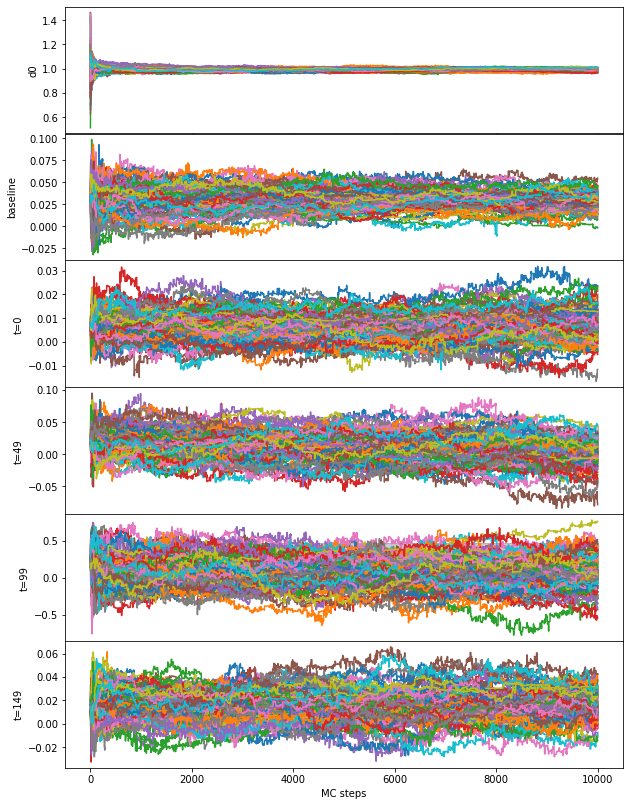

In [46]:
n_plots = 6
n_walkers = 100
n_steps = sample_mcmc.shape[1]
idx_list = [0, 1] + (np.linspace(1, len(vel_step1), n_plots-2, dtype=int)+1).tolist()
fig, ax = plt.subplots(n_plots, figsize=(10, 14))
plt.subplots_adjust(hspace = .001)
for i in range(n_plots):
    for j in range(n_walkers):
        ax[i].plot(sample_mcmc[j,:,idx_list[i]])
    if i>1:
        ax[i].set_ylabel('t=' + str(idx_list[i]-2))
        prior_val = vel_step1[idx_list[i]-2]
        ax[i].fill_between([0, n_steps], [prior_val-rel_prior_std*prior_val, prior_val-rel_prior_std*prior_val],\
                           [prior_val+rel_prior_std*prior_val, prior_val+rel_prior_std*prior_val], color='k', alpha=.2)
        ax[i].hlines(prior_val, 0, sample_mcmc.shape[1], colors='k', linestyles='dashed')
ax[0].set_ylabel('d0')
ax[0].fill_between([0, n_steps], [corr_prior[0][0]-corr_prior[1][0], corr_prior[0][0]-corr_prior[1][0]],\
                   [corr_prior[0][0]+corr_prior[1][0], corr_prior[0][0]+corr_prior[1][0]], color='k', alpha=.2)
ax[0].hlines(corr_prior[0][0], 0, n_steps, colors='k', linestyles='dashed')
ax[1].set_ylabel('baseline')
ax[1].fill_between([0, n_steps], [corr_prior[0][1]-corr_prior[1][1], corr_prior[0][1]-corr_prior[1][1]],\
                   [corr_prior[0][1]+corr_prior[1][1], corr_prior[0][1]+corr_prior[1][1]], color='k', alpha=.2)
ax[1].hlines(corr_prior[0][1], 0, n_steps, colors='k', linestyles='dashed')
ax[-1].set_xlabel('MC steps')

Burn in looks like only a few hundred MC steps: that's easy, we can remove it. However, it looks like correlation time is super long... Computing 500 or 10000 steps doesn't make a huge difference. Now let's compare prior and posterior speeds:

In [47]:
def getPosterior(MC_traces, burnin_steps=100, quantiles=[0.16,0.50,0.84]):
    samples_corr = MC_traces[:,burnin_steps:,:]
    traces = samples_corr.reshape(-1, MC_traces.shape[2]).T
    builder_corr_dict = {}
    builder_corr_dict['d0'] = np.absolute(traces[0])
    builder_corr_dict['base'] = np.absolute(traces[1])
    for i in range(2,MC_traces.shape[2]):
        builder_corr_dict['v'+str(i-2)] = np.absolute(traces[i])
    parameter_samples_corr = pd.DataFrame(builder_corr_dict)
    q_corr = parameter_samples_corr.quantile(quantiles, axis=0)
    v_res = np.empty((len(quantiles), len(vel_step1)))
    for q in range(len(quantiles)):
        for i in range(len(vel_step1)):
            v_res[q][i] = q_corr['v'+str(i)][quantiles[q]]
    return v_res
def comparePosterior(MC_traces):
    vvals = getPosterior(MC_traces)
    xvals = np.arange(vvals.shape[1])
    fig, ax = plt.subplots()
    ax.set_title('prior MSE: {0:.3f} - posterior MSE: {1:.3f}'.format(np.nanmean(compute_MSE(vel_step1)),\
                                                                     np.nanmean(compute_MSE(vvals[1]))))
    ax.fill_between(xvals, vvals[0], vvals[2], color='b', alpha=.2)
    ax.plot(xvals, vvals[1], 'b-', label='best')
    ax.fill_between(xvals, vel_step1-rel_prior_std*vel_step1, vel_step1+rel_prior_std*vel_step1, color='r', alpha=.2)
    ax.plot(xvals, vel_step1, 'r--', label='orig')
    ax.legend()
    ax.set_xlim([50, 150])
    return vvals

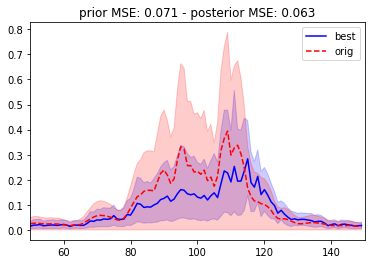

In [48]:
vvals = comparePosterior(sample_mcmc)

Does it actually do a much better job predicting the correlation maps?

MSE before optimization: 0.07072955766690726
MSE after optimization: 0.06256611794607879


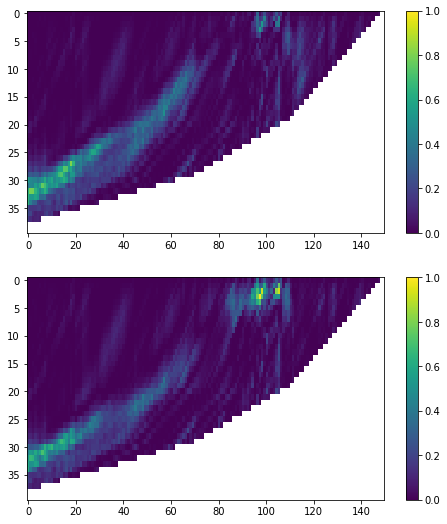

In [54]:
prev_MSE = compute_MSE(vel_step1)
cur_MSE = compute_MSE(vvals[1])
print('MSE before optimization: ' + str(np.nanmean(prev_MSE)))
print('MSE after optimization: ' + str(np.nanmean(cur_MSE)))
fig, ax = plt.subplots(2, figsize=(8,9))
cb0 = ax[0].imshow(prev_MSE, aspect='auto', vmin=0, vmax=1)
fig.colorbar(cb0, ax=ax[0])
cb1 = ax[1].imshow(cur_MSE, aspect='auto', vmin=0, vmax=1)
fig.colorbar(cb1, ax=ax[1])